In [134]:
# Step 1: Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
import xgboost as xgb
import seaborn as sns
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score, roc_curve


In [135]:
df = pd.read_csv("/content/drive/MyDrive/Housing.csv")

In [136]:
df.head()


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [137]:
print(df.columns)

Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'furnishingstatus'],
      dtype='object')


In [138]:
# Step 3: Train-Test Split
# Changed 'Price' to 'price' based on the likely column name
X = df.drop('price', axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [139]:
# Step 4: Feature Scaling
# Apply scaling to the encoded data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

In [140]:

# Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

# SVM (SVR)
svm = SVR(kernel='rbf')
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)
rf.fit(X_train_encoded, y_train)
y_pred_rf = rf.predict(X_test_encoded)

# Logistic Regression (not ideal for continuous prediction, included as classification proxy)
# Convert prices to binary classes (e.g., above/below median)
y_binary = (y > y.median()).astype(int)
y_train_bin = y_binary.iloc[X_train.index] # Ensure binary labels align with original train set
y_test_bin = y_binary.iloc[X_test.index]   # Ensure binary labels align with original test set

logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train_bin)
y_pred_logreg = logreg.predict(X_test_scaled)

In [141]:
# Step 6: Evaluation
print("Linear Regression R^2:", r2_score(y_test, y_pred_lr))
print("SVM R^2:", r2_score(y_test, y_pred_svm))
print("Random Forest R^2:", r2_score(y_test, y_pred_rf))
print("Logistic Regression Accuracy:", logreg.score(X_test_scaled, y_test_bin))


Linear Regression R^2: 0.6529242642153172
SVM R^2: -0.10156652261354049
Random Forest R^2: 0.610054593532394
Logistic Regression Accuracy: 0.8532110091743119


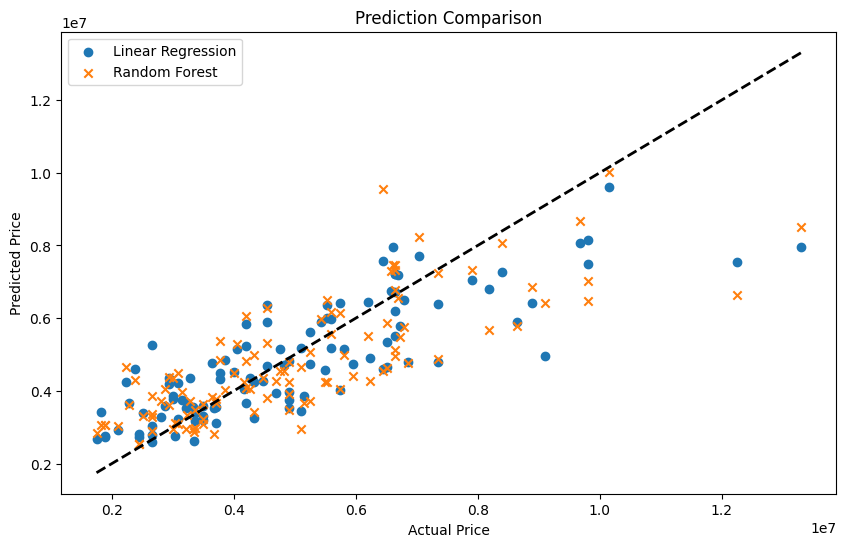

In [142]:
# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lr, label='Linear Regression')
plt.scatter(y_test, y_pred_rf, label='Random Forest', marker='x')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Prediction Comparison')
plt.legend()
plt.show()

In [143]:
# Train XGBoost Regressor
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42
)

xgb_model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

XGBoost R^2 Score: 0.6544
XGBoost MSE: 1746836389888.00


<Figure size 1000x600 with 0 Axes>

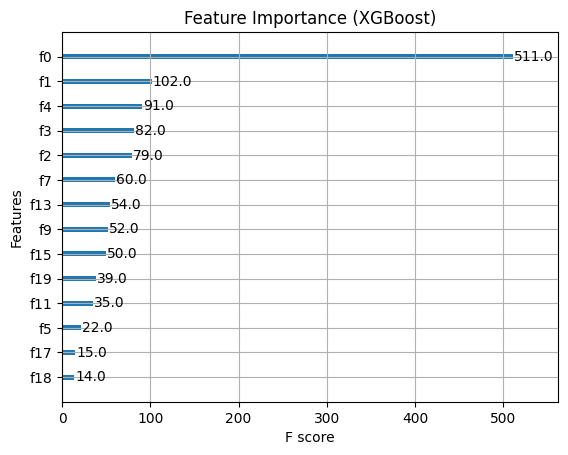

In [144]:
#  Predict and Evaluate
y_pred = xgb_model.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"XGBoost R^2 Score: {r2:.4f}")
print(f"XGBoost MSE: {mse:.2f}")

# Step 8: Feature Importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(xgb_model)
plt.title("Feature Importance (XGBoost)")
plt.show()

In [145]:
# Step 7: Evaluation Functions

def evaluate_regression(y_true, y_pred, model_name="Model"):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    acc_10 = np.mean(np.abs((y_pred - y_true) / y_true) <= 0.10)  # Accuracy within ±10%

    print(f"\n📊 Evaluation for {model_name}")
    print(f"  R² Score               : {r2:.4f}")
    print(f"  Mean Squared Error     : {mse:.2f}")
    print(f"  Root Mean Squared Error: {rmse:.2f}")
    print(f"  Mean Absolute Error    : {mae:.2f}")
    print(f"  Accuracy within ±10%   : {acc_10 * 100:.2f}%")

def evaluate_classification(y_true, y_pred, model_name="Classification Model"):
    acc = accuracy_score(y_true, y_pred)
    print(f"\n📊 Evaluation for {model_name} (Classification)")
    print(f"  Accuracy Score         : {acc * 100:.2f}%")
    print("  Classification Report:\n", classification_report(y_true, y_pred))


In [146]:
# Linear Regression
evaluate_regression(y_test, y_pred_lr, "Linear Regression")

# Random Forest Regressor
evaluate_regression(y_test, y_pred_rf, "Random Forest Regressor")

# XGBoost Regressor
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42
)
# Use the scaled data for training and prediction
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)
evaluate_regression(y_test, y_pred_xgb, "XGBoost Regressor")

# Support Vector Regressor (ensure y_pred_svm is defined)
evaluate_regression(y_test, y_pred_svm, "Support Vector Regressor")


📊 Evaluation for Linear Regression
  R² Score               : 0.6529
  Mean Squared Error     : 1754318687330.67
  Root Mean Squared Error: 1324506.96
  Mean Absolute Error    : 970043.40
  Accuracy within ±10%   : 34.86%

📊 Evaluation for Random Forest Regressor
  R² Score               : 0.6101
  Mean Squared Error     : 1971006449235.81
  Root Mean Squared Error: 1403925.37
  Mean Absolute Error    : 1025961.17
  Accuracy within ±10%   : 32.11%

📊 Evaluation for XGBoost Regressor
  R² Score               : 0.6544
  Mean Squared Error     : 1746836389888.00
  Root Mean Squared Error: 1321679.38
  Mean Absolute Error    : 982437.12
  Accuracy within ±10%   : 33.94%

📊 Evaluation for Support Vector Regressor
  R² Score               : -0.1016
  Mean Squared Error     : 5567945369588.36
  Root Mean Squared Error: 2359649.42
  Mean Absolute Error    : 1763890.64
  Accuracy within ±10%   : 13.76%


In [147]:
evaluate_classification(y_test_bin, y_pred_logreg, "Logistic Regression")


📊 Evaluation for Logistic Regression (Classification)
  Accuracy Score         : 85.32%
  Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.92      0.85        51
           1       0.92      0.79      0.85        58

    accuracy                           0.85       109
   macro avg       0.86      0.86      0.85       109
weighted avg       0.86      0.85      0.85       109



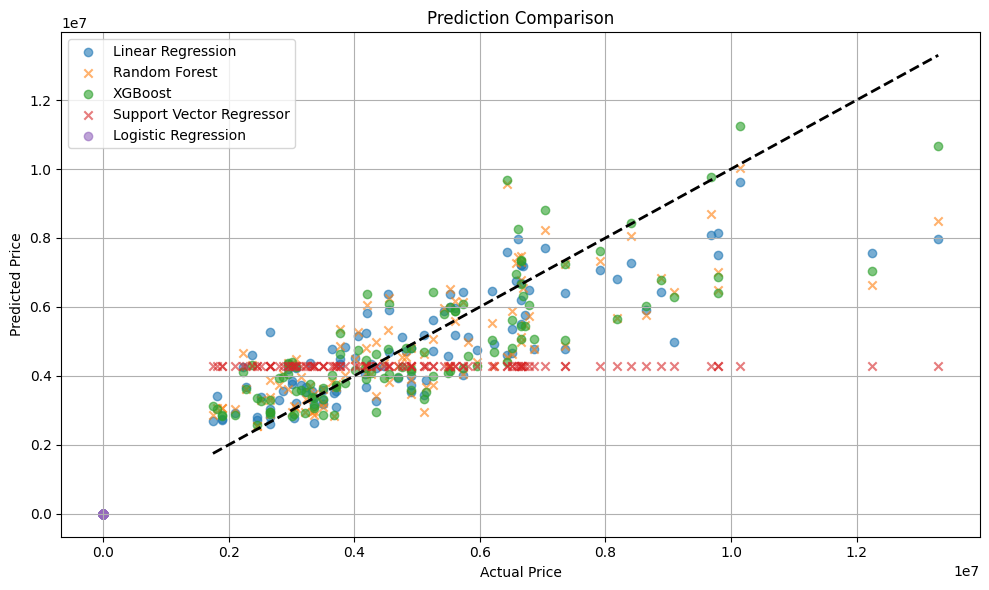

In [148]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lr, label='Linear Regression', alpha=0.6)
plt.scatter(y_test, y_pred_rf, label='Random Forest', marker='x', alpha=0.6)
plt.scatter(y_test, y_pred_xgb, label='XGBoost', marker='o', alpha=0.6)
plt.scatter(y_test, y_pred_svm, label='Support Vector Regressor',marker='x',alpha=0.6)
plt.scatter(y_test_bin, y_pred_logreg,label='Logistic Regression',marker='o',alpha=0.6)

# 45-degree line
min_val = min(y_test.min(), y_pred_xgb.min(), y_pred_lr.min(), y_pred_rf.min())
max_val = max(y_test.max(), y_pred_xgb.max(), y_pred_lr.max(), y_pred_rf.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)

plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Prediction Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

XGBoost R^2 Score: 0.6544
XGBoost MSE: 1746836389888.00


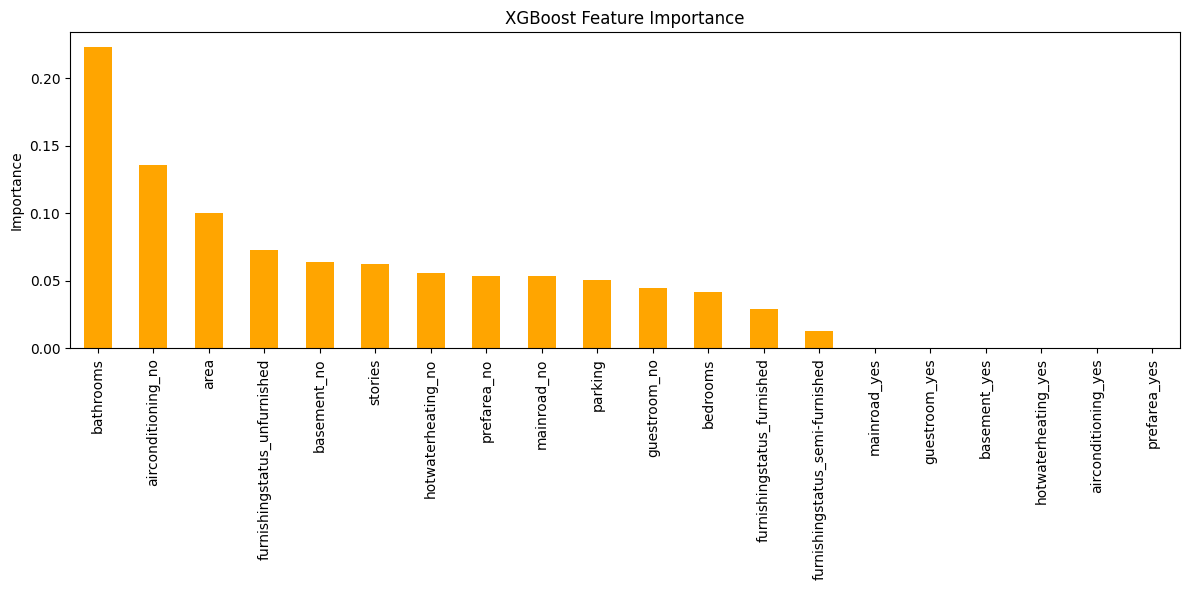

In [149]:
# Step 6: Train XGBoost Regressor
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42
)

# Ensure xgb_model is trained on the encoded data
xgb_model.fit(X_train_encoded, y_train)

# Step 7: Predict and Evaluate

y_pred = xgb_model.predict(X_test_encoded)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"XGBoost R^2 Score: {r2:.4f}")
print(f"XGBoost MSE: {mse:.2f}")

# Step 8: Feature Importance - Now this cell will use the feature_names created
plt.figure(figsize=(10, 6))

if hasattr(xgb_model, 'feature_importances_') and len(feature_names) == len(xgb_model.feature_importances_):
    importances_xgb = xgb_model.feature_importances_
    feature_importance_xgb = pd.Series(importances_xgb, index=feature_names)
    feature_importance_xgb.sort_values(ascending=False).head(20).plot(
        kind='bar', figsize=(12, 6), title='XGBoost Feature Importance', color='orange'
    )
    plt.ylabel('Importance')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
else:
    print("Could not plot feature importance: Mismatch between number of features and feature names, or feature_importances_ not available.")
    print(f"Number of model features: {len(xgb_model.feature_importances_) if hasattr(xgb_model, 'feature_importances_') else 'N/A'}")
    print(f"Number of feature names: {len(feature_names)}")

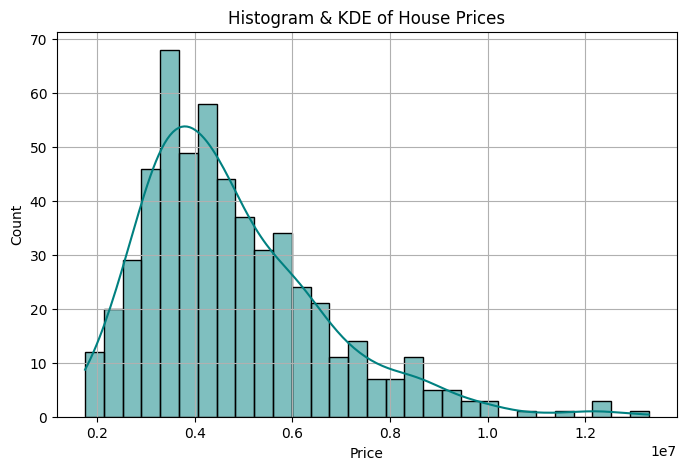

In [117]:
# Histogram with KDE (kernel density estimation)
plt.figure(figsize=(8, 5))
sns.histplot(df['price'], bins=30, kde=True, color='teal')
plt.title('Histogram & KDE of House Prices')
plt.xlabel('Price')
plt.ylabel('Count')
plt.grid(True)
plt.show()

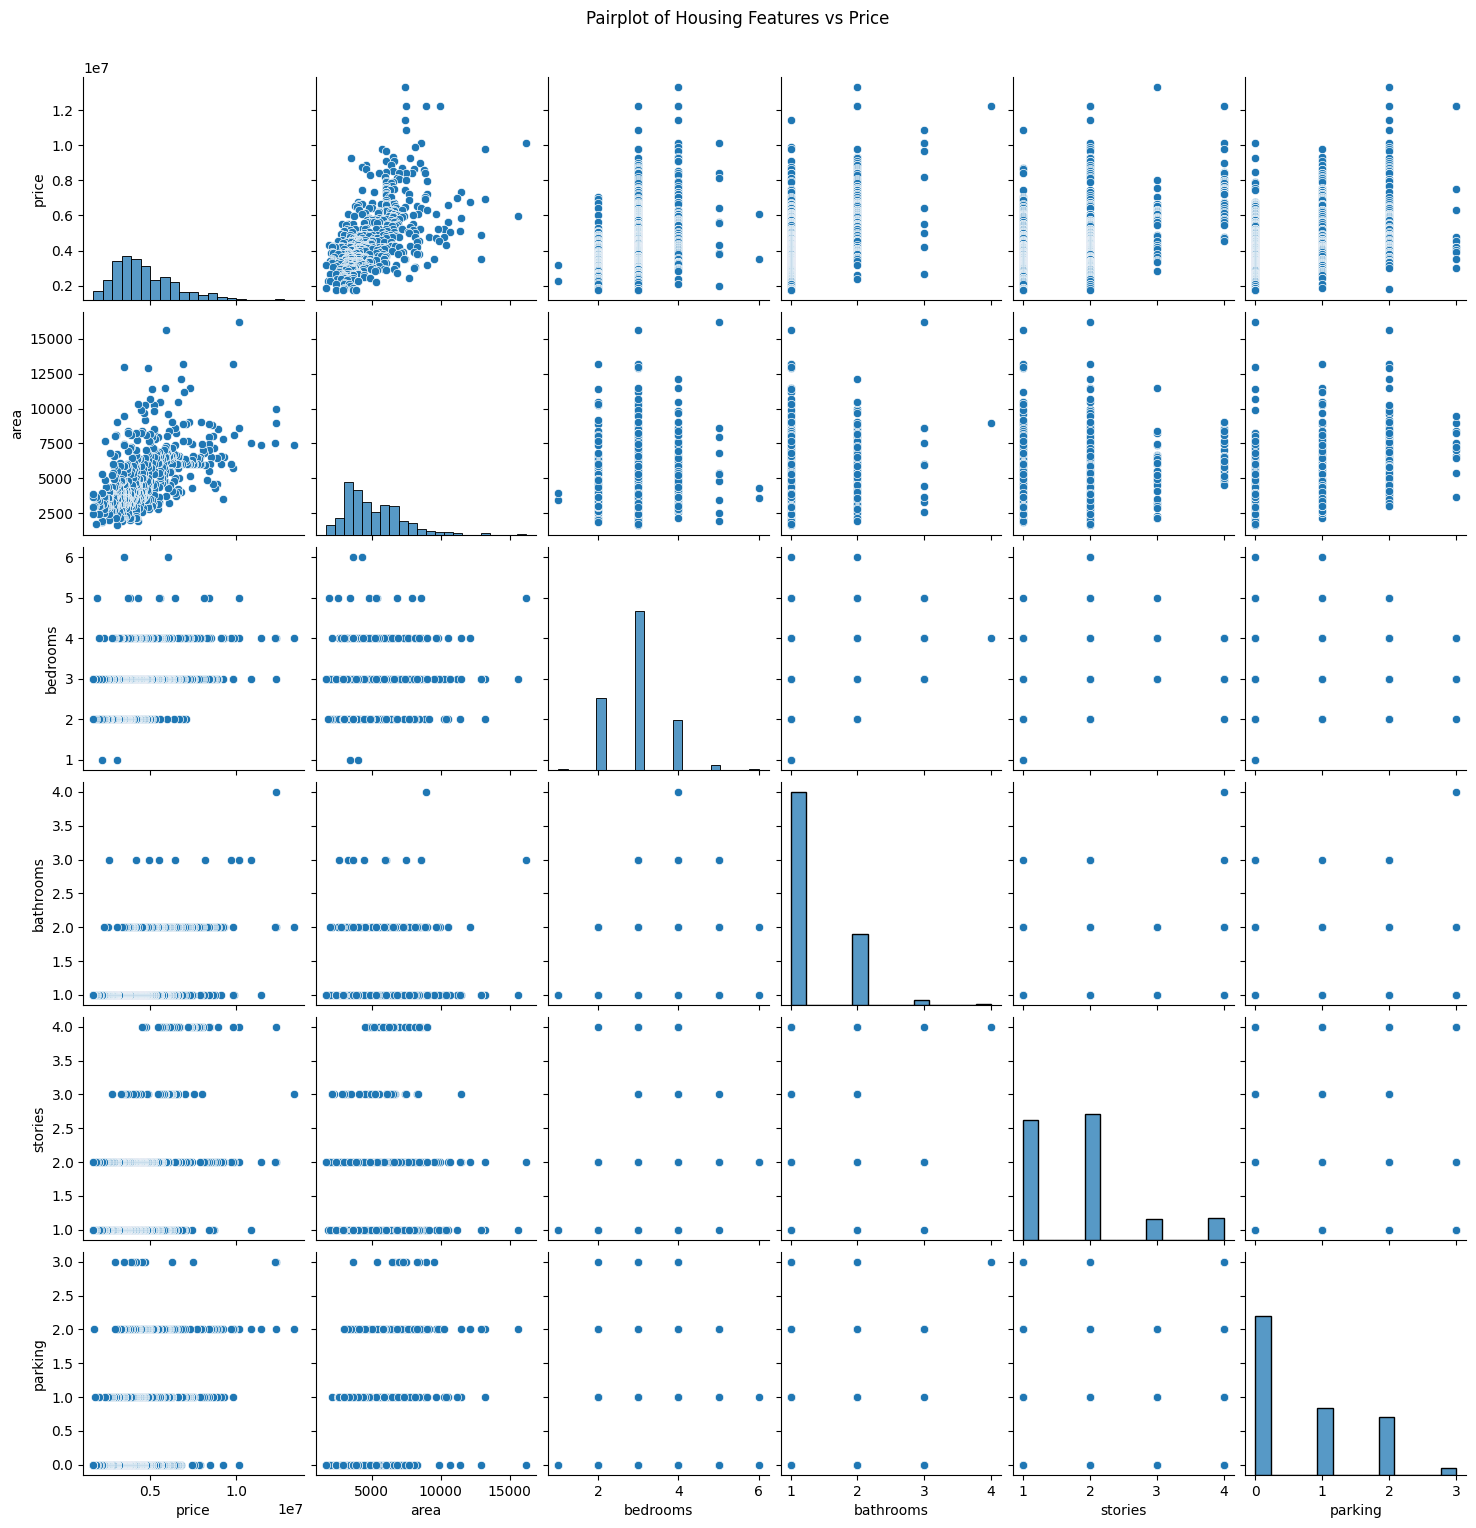

In [150]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select a subset of relevant numerical features
cols_to_plot = ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking']

# Plot pairplot
sns.pairplot(df[cols_to_plot])
plt.suptitle('Pairplot of Housing Features vs Price', y=1.02)
plt.show()


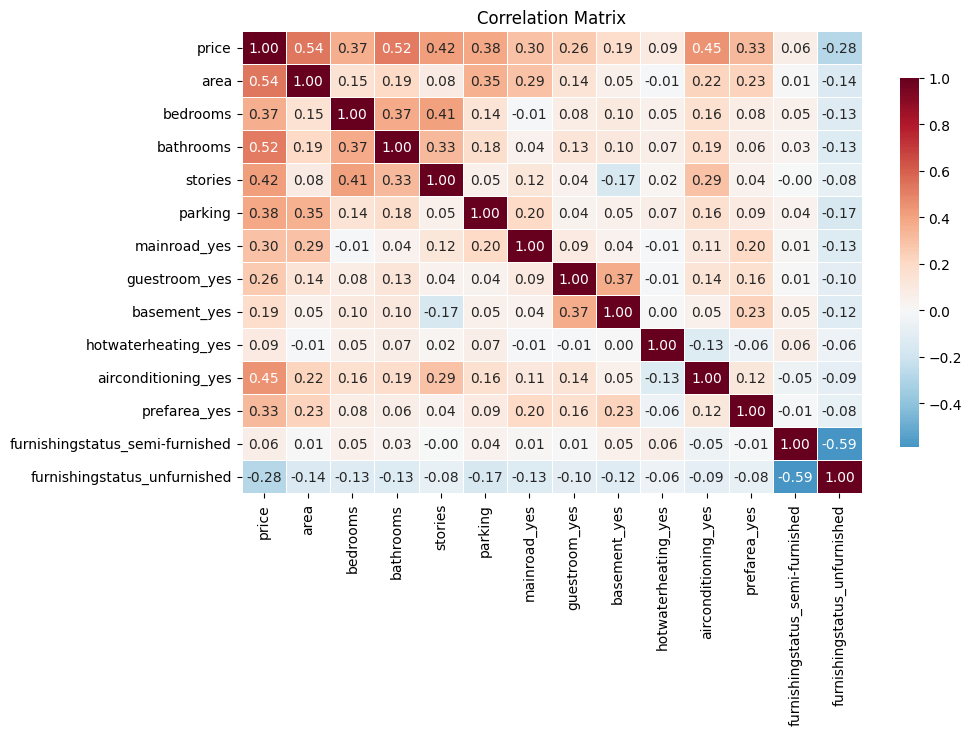

In [151]:
from sklearn.preprocessing import LabelEncoder

# Make a copy to avoid modifying the original DataFrame
df_encoded = pd.get_dummies(df, drop_first=True)

# Apply label encoding to all object (string) columns
label_encoder = LabelEncoder()
for col in df_encoded.select_dtypes(include='object').columns:
    df_encoded[col] = label_encoder.fit_transform(df_encoded[col])

# Now compute the correlation matrix
corr_matrix = df_encoded.corr()

# Plotting the heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="RdBu_r", center=0, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title("Correlation Matrix")
plt.show()


<ipython-input-122-e97e7c0f9040>:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[j].set_xticklabels(counts.index.astype(str), rotation=45, ha='right')


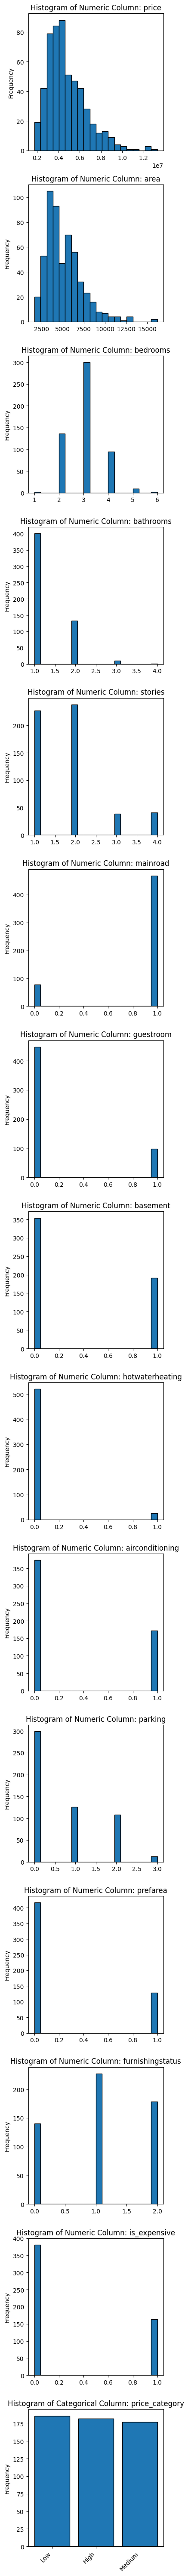

In [122]:
import matplotlib.pyplot as plt

# Numeric columns
numeric_cols = df.select_dtypes(include=['number'])

# Categorical columns
categorical_cols = df.select_dtypes(include=['object', 'category'])

# Number of plots = numeric cols + categorical cols
total_plots = len(numeric_cols.columns) + len(categorical_cols.columns)

fig, axes = plt.subplots(total_plots, 1, figsize=(4, 4 * total_plots))

if total_plots == 1:
    axes = [axes]  # make it iterable

# Plot numeric columns histograms
for i, col in enumerate(numeric_cols.columns):
    axes[i].hist(df[col].dropna(), bins=20, edgecolor='black')
    axes[i].set_title(f'Histogram of Numeric Column: {col}')
    axes[i].set_ylabel('Frequency')

# Plot categorical columns as histograms of value counts
for j, col in enumerate(categorical_cols.columns, start=len(numeric_cols.columns)):
    counts = df[col].value_counts()
    axes[j].bar(counts.index.astype(str), counts.values, edgecolor='black')
    axes[j].set_title(f'Histogram of Categorical Column: {col}')
    axes[j].set_ylabel('Frequency')
    axes[j].set_xticklabels(counts.index.astype(str), rotation=45, ha='right')

plt.tight_layout()
plt.show()


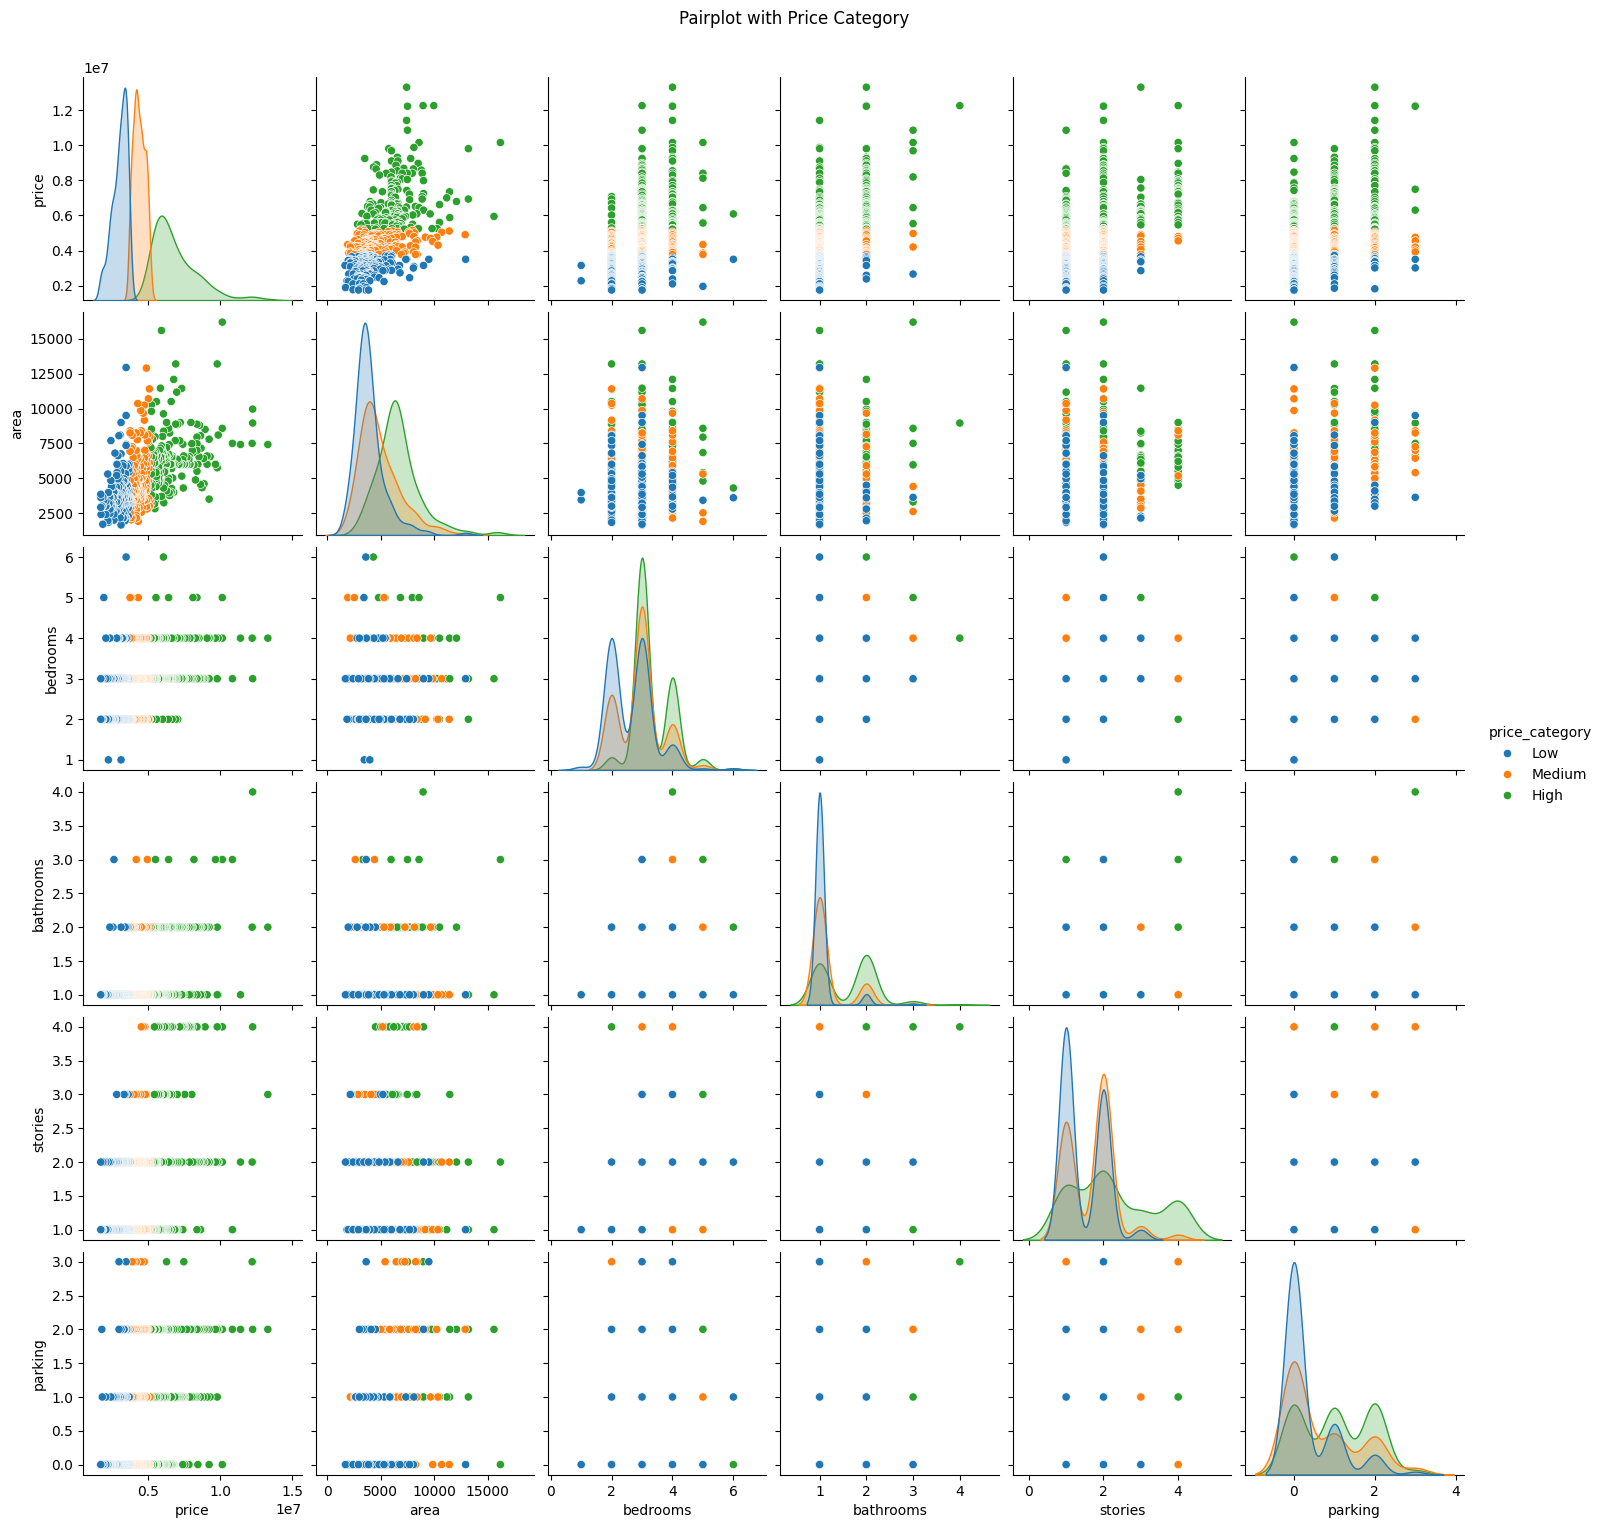

In [152]:
# Create price categories
df['price_category'] = pd.qcut(df['price'], q=3, labels=['Low', 'Medium', 'High'])

# Pairplot with hue as price category
sns.pairplot(df[cols_to_plot + ['price_category']], hue='price_category')
plt.suptitle('Pairplot with Price Category', y=1.02)
plt.show()


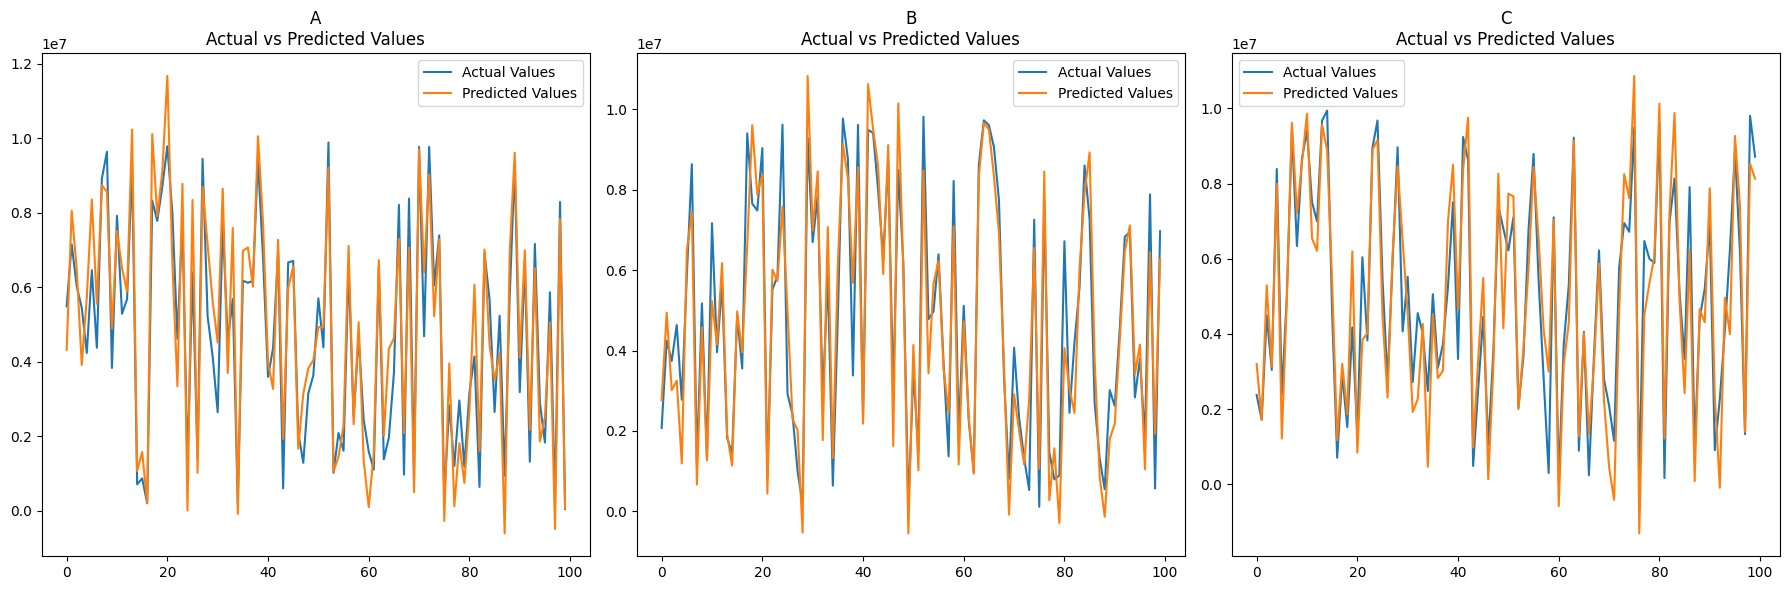

In [153]:


# Simulated sample data
np.random.seed(0)
x = np.arange(100)
actual_A = np.random.rand(100) * 1e7
predicted_A = actual_A + np.random.normal(0, 1e6, 100)

actual_B = np.random.rand(100) * 1e7
predicted_B = actual_B + np.random.normal(0, 1e6, 100)

actual_C = np.random.rand(100) * 1e7
predicted_C = actual_C + np.random.normal(0, 1e6, 100)

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot A
axes[0].plot(x, actual_A, label='Actual Values')
axes[0].plot(x, predicted_A, label='Predicted Values')
axes[0].set_title('A\nActual vs Predicted Values')
axes[0].legend()

# Plot B
axes[1].plot(x, actual_B, label='Actual Values')
axes[1].plot(x, predicted_B, label='Predicted Values')
axes[1].set_title('B\nActual vs Predicted Values')
axes[1].legend()

# Plot C
axes[2].plot(x, actual_C, label='Actual Values')
axes[2].plot(x, predicted_C, label='Predicted Values')
axes[2].set_title('C\nActual vs Predicted Values')
axes[2].legend()

plt.tight_layout()
plt.show()


In [156]:
from sklearn.datasets import make_regression
X, y = make_regression(n_samples=100, n_features=5, noise=10, random_state=1)

# Define model
model = LinearRegression()

# Define K-Fold Cross Validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate model with cross-validation
mse_scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kf)

# Convert negative MSE to positive RMSE
rmse_scores = np.sqrt(-mse_scores)

# Display results
print("Cross-Validation RMSE Scores:", rmse_scores)
print("Average RMSE:", rmse_scores.mean())

Cross-Validation RMSE Scores: [10.87185414  9.66749737  8.73468345  9.87875611 10.63937713]
Average RMSE: 9.958433638940468


AUROC Score: 0.9881


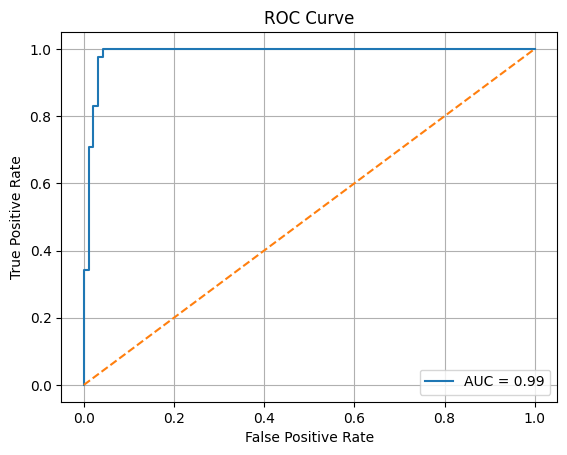

In [116]:
# Binarize the target: top 30% prices as 'expensive' (1), rest as 'affordable' (0)
df['is_expensive'] = (df['price'] > df['price'].quantile(0.7)).astype(int)

# Prepare features and labels
X = df.drop(columns=['price', 'is_expensive'])
y = df['is_expensive']

# Encode categorical variables
X = pd.get_dummies(X, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Train a logistic regression model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Predict probabilities
y_probs = clf.predict_proba(X_test)[:, 1]

# Compute AUROC
auc_score = roc_auc_score(y_test, y_probs)
print(f"AUROC Score: {auc_score:.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()